In [1]:
import os
import subprocess
import matplotlib.pyplot as plt
import numpy as np
from ase.build import bulk
from ase.io import write
from adis_tools.parsers import parse_pw
from pyiron_base import job, Project
from pyiron_base.project.delayed import draw, DelayedObject

In [2]:
def get_kwargs(lst):
    return {t['targetHandle']: {'source': t['source'], 'sourceHandle': t['sourceHandle']} for t in lst}

In [3]:
def resort_total_lst(total_lst, nodes_dict):
    nodes_with_dep_lst = list(sorted([v[0] for v in total_lst]))
    nodes_without_dep_lst = [k for k in nodes_dict.keys() if k not in nodes_with_dep_lst]
    ordered_lst, total_new_lst = [], []
    while len(total_new_lst) < len(total_lst):
        for ind, connect in total_lst:
            if ind not in ordered_lst:
                source_lst = [sd["source"] for sd in connect.values()]
                if all([s in ordered_lst or s in nodes_without_dep_lst for s in source_lst]):
                    ordered_lst.append(ind)
                    total_new_lst.append([ind, connect])
    return total_new_lst

In [4]:
def group_edges(edges_lst):
    edges_sorted_lst = sorted(edges_lst, key=lambda x: x['target'], reverse=True)     
    total_lst, tmp_lst = [], []
    target_id = edges_sorted_lst[0]['target'] 
    for ed in edges_sorted_lst:
        if target_id == ed["target"]:
            tmp_lst.append(ed)
        else:
            total_lst.append((target_id, get_kwargs(lst=tmp_lst)))
            target_id = ed["target"]
            tmp_lst = [ed]
    total_lst.append((target_id, get_kwargs(lst=tmp_lst)))
    return total_lst

In [5]:
def get_source_handles(edges_lst):
    source_handle_dict = {}
    for ed in edges_lst: 
        if ed['source'] not in source_handle_dict.keys():
            source_handle_dict[ed['source']] = [ed['sourceHandle']]
        else:
            source_handle_dict[ed['source']].append(ed['sourceHandle'])
    return {
        k: list(range(len(v))) if len(v) > 1 and all([el is None for el in v]) else v 
        for k, v in source_handle_dict.items()
    }

In [6]:
def get_source(nodes_dict, delayed_object_dict, source, sourceHandle):
    if source in delayed_object_dict.keys():
        return delayed_object_dict[source].__getattr__("output").__getattr__(sourceHandle)
    else:
        return nodes_dict[source]

In [7]:
def get_delayed_object_dict(total_lst, nodes_dict, source_handle_dict, pyiron_project):
    delayed_object_dict = {}
    for item in total_lst: 
        key, input_dict = item
        kwargs = {
            k: get_source(
                nodes_dict=nodes_dict, 
                delayed_object_dict=delayed_object_dict, 
                source=v["source"], 
                sourceHandle=v["sourceHandle"],
            ) 
            for k, v in input_dict.items()
        }
        # print(nodes_dict[key], source_handle_dict.get(key, []))
        delayed_object_dict[key] = job(
            funct=nodes_dict[key],
            output_key_lst=source_handle_dict.get(key, []),
        )(**kwargs, pyiron_project=pyiron_project)
    return delayed_object_dict

In [8]:
def get_dict(**kwargs):
    return {k: v for k, v in kwargs["kwargs"].items()}

In [9]:
def get_list(**kwargs):
    return list(kwargs["kwargs"].values())

In [10]:
def write_input(input_dict, working_directory="."):
    filename = os.path.join(working_directory, "input.pwi")
    os.makedirs(working_directory, exist_ok=True)
    write(
        filename=filename,
        images=input_dict["structure"],
        Crystal=True,
        kpts=input_dict["kpts"],
        input_data={
            "calculation": input_dict["calculation"],
            "occupations": "smearing",
            "degauss": input_dict["smearing"],
        },
        pseudopotentials=input_dict["pseudopotentials"],
        tstress=True,
        tprnfor=True,
    )

In [11]:
def collect_output(working_directory="."):
    output = parse_pw(os.path.join(working_directory, "pwscf.xml"))
    return {
        "structure": output["ase_structure"],
        "energy": output["energy"],
        "volume": output["ase_structure"].get_volume(),
    }

In [12]:
# @job(output_key_lst=["energy", "volume", "structure"])
def calculate_qe(working_directory, input_dict):
    write_input(
        input_dict=input_dict,
        working_directory=working_directory,
    )
    subprocess.check_output(
        "mpirun -np 1 pw.x -in input.pwi > output.pwo",
        cwd=working_directory,
        shell=True,
    )
    return collect_output(working_directory=working_directory)

In [13]:
# @job
def generate_structures(structure, strain_lst):
    structure_lst = []
    for strain in strain_lst:
        structure_strain = structure.copy()
        structure_strain.set_cell(
            structure_strain.cell * strain ** (1 / 3), scale_atoms=True
        )
        structure_lst.append(structure_strain)
    return structure_lst

In [14]:
# @job
def plot_energy_volume_curve(volume_lst, energy_lst):
    plt.plot(volume_lst, energy_lst)
    plt.xlabel("Volume")
    plt.ylabel("Energy")
    plt.savefig("evcurve.png")

In [15]:
# @job
def get_bulk_structure(name, a, cubic):
    return bulk(
        name=name,
        a=a,
        cubic=cubic,
    )

In [16]:
pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}

In [17]:
nodes_new_dict = {
    0: plot_energy_volume_curve,
    1: get_list,
    2: calculate_qe,
    3: get_dict,
    4: generate_structures,
    5: calculate_qe,
    6: get_dict,
    7: get_bulk_structure,
    8: calculate_qe,
    9: get_dict,
    10: calculate_qe,
    11: get_dict,
    12: calculate_qe,
    13: get_dict,
    14: calculate_qe,
    15: get_dict,
    16: get_list,
    17: 'strain_0',
    18: 'mini',
    19: 'Al',
    20: 4.05,
    21: True,
    22: {'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF'},
    23: (3, 3, 3),
    24: 'vc-relax',
    25: 0.02,
    26: np.array([0.9 , 0.95, 1.  , 1.05, 1.1 ]),
    27: 'scf',
    28: 'strain_1',
    29: 'strain_2',
    30: 'strain_3',
    31: 'strain_4',
}

In [18]:
edges_new_lst = [
    {'target': 0, 'targetHandle': 'volume_lst', 'source': 1, 'sourceHandle': None},
    {'target': 1, 'targetHandle': '0', 'source': 2, 'sourceHandle': 'volume'},
    {'target': 2, 'targetHandle': 'working_directory', 'source': 17, 'sourceHandle': None},
    {'target': 2, 'targetHandle': 'input_dict', 'source': 3, 'sourceHandle': None},
    {'target': 3, 'targetHandle': 'structure', 'source': 4, 'sourceHandle': 0},
    {'target': 4, 'targetHandle': 'structure', 'source': 5, 'sourceHandle': 'structure'},
    {'target': 5, 'targetHandle': 'working_directory', 'source': 18, 'sourceHandle': None},
    {'target': 5, 'targetHandle': 'input_dict', 'source': 6, 'sourceHandle': None},
    {'target': 6, 'targetHandle': 'structure', 'source': 7, 'sourceHandle': None},
    {'target': 7, 'targetHandle': 'name', 'source': 19, 'sourceHandle': None},
    {'target': 7, 'targetHandle': 'a', 'source': 20, 'sourceHandle': None},
    {'target': 7, 'targetHandle': 'cubic', 'source': 21, 'sourceHandle': None},
    {'target': 6, 'targetHandle': 'pseudopotentials', 'source': 22, 'sourceHandle': None},
    {'target': 6, 'targetHandle': 'kpts', 'source': 23, 'sourceHandle': None},
    {'target': 6, 'targetHandle': 'calculation', 'source': 24, 'sourceHandle': None},
    {'target': 6, 'targetHandle': 'smearing', 'source': 25, 'sourceHandle': None},
    {'target': 4, 'targetHandle': 'strain_lst', 'source': 26, 'sourceHandle': None},
    {'target': 3, 'targetHandle': 'pseudopotentials', 'source': 22, 'sourceHandle': None},
    {'target': 3, 'targetHandle': 'kpts', 'source': 23, 'sourceHandle': None},
    {'target': 3, 'targetHandle': 'calculation', 'source': 27, 'sourceHandle': None},
    {'target': 3, 'targetHandle': 'smearing', 'source': 25, 'sourceHandle': None},
    {'target': 1, 'targetHandle': '1', 'source': 8, 'sourceHandle': 'volume'},
    {'target': 8, 'targetHandle': 'working_directory', 'source': 28, 'sourceHandle': None},
    {'target': 8, 'targetHandle': 'input_dict', 'source': 9, 'sourceHandle': None},
    {'target': 9, 'targetHandle': 'structure', 'source': 4, 'sourceHandle': 1},
    {'target': 9, 'targetHandle': 'pseudopotentials', 'source': 22, 'sourceHandle': None},
    {'target': 9, 'targetHandle': 'kpts', 'source': 23, 'sourceHandle': None},
    {'target': 9, 'targetHandle': 'calculation', 'source': 27, 'sourceHandle': None},
    {'target': 9, 'targetHandle': 'smearing', 'source': 25, 'sourceHandle': None},
    {'target': 1, 'targetHandle': '2', 'source': 10, 'sourceHandle': 'volume'},
    {'target': 10, 'targetHandle': 'working_directory', 'source': 29, 'sourceHandle': None},
    {'target': 10, 'targetHandle': 'input_dict', 'source': 11, 'sourceHandle': None},
    {'target': 11, 'targetHandle': 'structure', 'source': 4, 'sourceHandle': 2},
    {'target': 11, 'targetHandle': 'pseudopotentials', 'source': 22, 'sourceHandle': None},
    {'target': 11, 'targetHandle': 'kpts', 'source': 23, 'sourceHandle': None},
    {'target': 11, 'targetHandle': 'calculation', 'source': 27, 'sourceHandle': None},
    {'target': 11, 'targetHandle': 'smearing', 'source': 25, 'sourceHandle': None},
    {'target': 1, 'targetHandle': '3', 'source': 12, 'sourceHandle': 'volume'},
    {'target': 12, 'targetHandle': 'working_directory', 'source': 30, 'sourceHandle': None},
    {'target': 12, 'targetHandle': 'input_dict', 'source': 13, 'sourceHandle': None},
    {'target': 13, 'targetHandle': 'structure', 'source': 4, 'sourceHandle': 3},
    {'target': 13, 'targetHandle': 'pseudopotentials', 'source': 22, 'sourceHandle': None},
    {'target': 13, 'targetHandle': 'kpts', 'source': 23, 'sourceHandle': None},
    {'target': 13, 'targetHandle': 'calculation', 'source': 27, 'sourceHandle': None},
    {'target': 13, 'targetHandle': 'smearing', 'source': 25, 'sourceHandle': None},
    {'target': 1, 'targetHandle': '4', 'source': 14, 'sourceHandle': 'volume'},
    {'target': 14, 'targetHandle': 'working_directory', 'source': 31, 'sourceHandle': None},
    {'target': 14, 'targetHandle': 'input_dict', 'source': 15, 'sourceHandle': None},
    {'target': 15, 'targetHandle': 'structure', 'source': 4, 'sourceHandle': 4},
    {'target': 15, 'targetHandle': 'pseudopotentials', 'source': 22, 'sourceHandle': None},
    {'target': 15, 'targetHandle': 'kpts', 'source': 23, 'sourceHandle': None},
    {'target': 15, 'targetHandle': 'calculation', 'source': 27, 'sourceHandle': None},
    {'target': 15, 'targetHandle': 'smearing', 'source': 25, 'sourceHandle': None},
    {'target': 0, 'targetHandle': 'energy_lst', 'source': 16, 'sourceHandle': None},
    {'target': 16, 'targetHandle': '0', 'source': 2, 'sourceHandle': 'energy'},
    {'target': 16, 'targetHandle': '1', 'source': 8, 'sourceHandle': 'energy'},
    {'target': 16, 'targetHandle': '2', 'source': 10, 'sourceHandle': 'energy'},
    {'target': 16, 'targetHandle': '3', 'source': 12, 'sourceHandle': 'energy'},
    {'target': 16, 'targetHandle': '4', 'source': 14, 'sourceHandle': 'energy'},
]

In [19]:
pr = Project("test")
pr.remove_jobs(recursive=True, silently=True)

  0%|          | 0/9 [00:00<?, ?it/s]

In [20]:
total_lst = group_edges(edges_new_lst)

In [21]:
total_new_lst = resort_total_lst(total_lst=total_lst, nodes_dict=nodes_new_dict)

In [22]:
source_handle_dict = get_source_handles(edges_new_lst)

In [23]:
delayed_object_dict = get_delayed_object_dict(
    total_lst=total_new_lst, 
    nodes_dict=nodes_new_dict, 
    source_handle_dict=source_handle_dict, 
    pyiron_project=pr
)

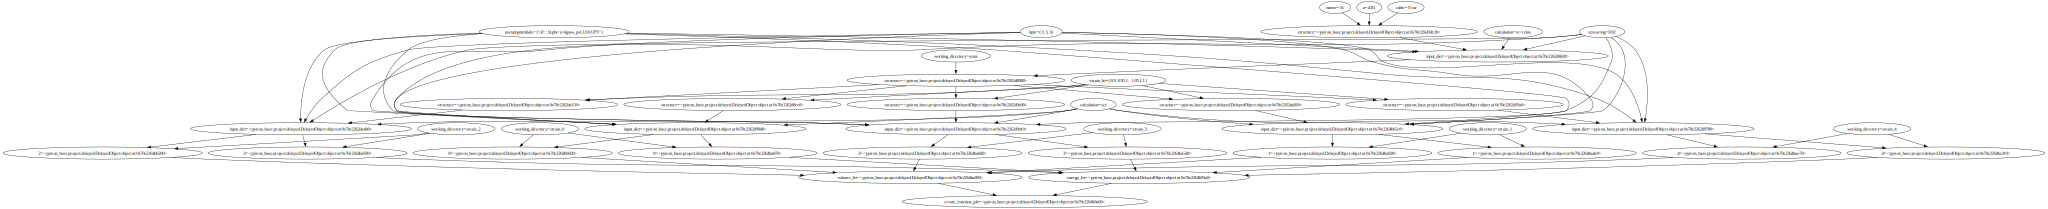

In [24]:
delayed_object_dict[list(delayed_object_dict.keys())[-1]].draw()

The job get_bulk_structure_5533ccd8a03e949b5b90cdb836a3d57e was saved and received the ID: 1988
The job get_dict_ca725027eabe1f1d766c0265329abec1 was saved and received the ID: 1989
The job calculate_qe_af7cacf8711e9d6e48a69cfca6a7e59c was saved and received the ID: 1990


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job generate_structures_ca9c71bd1a98ae980ef31f60b31c1f35 was saved and received the ID: 1991
The job get_dict_1e9208a07588332746306aa98db04f3b was saved and received the ID: 1992
The job calculate_qe_2f00d82a6427c6aabb3e15a66a34c656 was saved and received the ID: 1993


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_69de36cad039f5be7cbd2ee54178df95 was saved and received the ID: 1994
The job calculate_qe_8ccd019d140e905473e71bcc53223028 was saved and received the ID: 1995


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_1754bae5251cd1388b627d56abbf5f96 was saved and received the ID: 1996
The job calculate_qe_05a044d6f86502734df4b6449fab6973 was saved and received the ID: 1997


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_312ea79ee258459227056bea599e43b1 was saved and received the ID: 1998
The job calculate_qe_7588603b16e0e5b201247a28debc419c was saved and received the ID: 1999


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_85ce737509df42cb53a639f848b63ea9 was saved and received the ID: 2000
The job calculate_qe_1f3d28b0b37e5cffa88156dc86e912fa was saved and received the ID: 2001


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_list_17bbbc8ec4b0b94d3957dbeb585c8834 was saved and received the ID: 2002
The job get_list_08229479bca0de8be66c835759935991 was saved and received the ID: 2003
The job plot_energy_volume_curve_9e995df9cf9d88e3e7f7d697a9a88141 was saved and received the ID: 2004


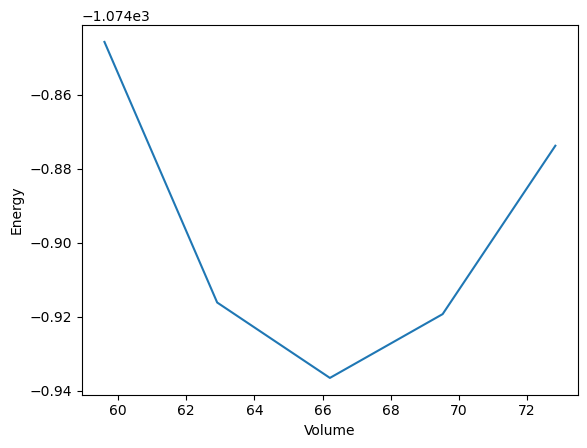

In [25]:
delayed_object_dict[list(delayed_object_dict.keys())[-1]].pull()

In [26]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,1988,finished,None,get_bulk_structure_5533ccd8a03e949b5b90cdb836a3d57e,/get_bulk_structure_5533ccd8a03e949b5b90cdb836a3d57e,None,/home/janssen/notebooks/2025/2025-01-11-quantum-espresso/test/,2025-01-16 13:36:00.707115,None,None,pyiron@cmpc06#1,PythonFunctionContainerJob,0.4,None,None
1,1989,finished,None,get_dict_ca725027eabe1f1d766c0265329abec1,/get_dict_ca725027eabe1f1d766c0265329abec1,None,/home/janssen/notebooks/2025/2025-01-11-quantum-espresso/test/,2025-01-16 13:36:01.349832,None,None,pyiron@cmpc06#1,PythonFunctionContainerJob,0.4,None,None
2,1990,finished,None,calculate_qe_af7cacf8711e9d6e48a69cfca6a7e59c,/calculate_qe_af7cacf8711e9d6e48a69cfca6a7e59c,None,/home/janssen/notebooks/2025/2025-01-11-quantum-espresso/test/,2025-01-16 13:36:01.982590,None,None,pyiron@cmpc06#1,PythonFunctionContainerJob,0.4,None,None
3,1991,finished,None,generate_structures_ca9c71bd1a98ae980ef31f60b31c1f35,/generate_structures_ca9c71bd1a98ae980ef31f60b31c1f35,None,/home/janssen/notebooks/2025/2025-01-11-quantum-espresso/test/,2025-01-16 13:36:15.988914,None,None,pyiron@cmpc06#1,PythonFunctionContainerJob,0.4,None,None
4,1992,finished,None,get_dict_1e9208a07588332746306aa98db04f3b,/get_dict_1e9208a07588332746306aa98db04f3b,None,/home/janssen/notebooks/2025/2025-01-11-quantum-espresso/test/,2025-01-16 13:36:16.627010,None,None,pyiron@cmpc06#1,PythonFunctionContainerJob,0.4,None,None
5,1993,finished,None,calculate_qe_2f00d82a6427c6aabb3e15a66a34c656,/calculate_qe_2f00d82a6427c6aabb3e15a66a34c656,None,/home/janssen/notebooks/2025/2025-01-11-quantum-espresso/test/,2025-01-16 13:36:17.257953,None,None,pyiron@cmpc06#1,PythonFunctionContainerJob,0.4,None,None
6,1994,finished,None,get_dict_69de36cad039f5be7cbd2ee54178df95,/get_dict_69de36cad039f5be7cbd2ee54178df95,None,/home/janssen/notebooks/2025/2025-01-11-quantum-espresso/test/,2025-01-16 13:36:21.344234,None,None,pyiron@cmpc06#1,PythonFunctionContainerJob,0.4,None,None
7,1995,finished,None,calculate_qe_8ccd019d140e905473e71bcc53223028,/calculate_qe_8ccd019d140e905473e71bcc53223028,None,/home/janssen/notebooks/2025/2025-01-11-quantum-espresso/test/,2025-01-16 13:36:21.964446,None,None,pyiron@cmpc06#1,PythonFunctionContainerJob,0.4,None,None
8,1996,finished,None,get_dict_1754bae5251cd1388b627d56abbf5f96,/get_dict_1754bae5251cd1388b627d56abbf5f96,None,/home/janssen/notebooks/2025/2025-01-11-quantum-espresso/test/,2025-01-16 13:36:26.240841,None,None,pyiron@cmpc06#1,PythonFunctionContainerJob,0.4,None,None
9,1997,finished,None,calculate_qe_05a044d6f86502734df4b6449fab6973,/calculate_qe_05a044d6f86502734df4b6449fab6973,None,/home/janssen/notebooks/2025/2025-01-11-quantum-espresso/test/,2025-01-16 13:36:26.863794,None,None,pyiron@cmpc06#1,PythonFunctionContainerJob,0.4,None,None
